In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Competition_Data.csv')
df.head()

,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
0,0,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,206.44
1,1,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,158.01
2,2,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,278.03
3,3,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,222.66
4,4,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,195.32


In [2]:
# looking into the columns
print("DataFrame Info:")
df.info()
print("\nDataFrame Description:")
df.describe()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Index                     100000 non-null  int64  
 1   Fiscal_Week_ID            100000 non-null  object 
 2   Store_ID                  100000 non-null  object 
 3   Item_ID                   100000 non-null  object 
 4   Price                     100000 non-null  float64
 5   Item_Quantity             100000 non-null  int64  
 6   Sales_Amount_No_Discount  100000 non-null  float64
 7   Sales_Amount              100000 non-null  float64
 8   Competition_Price         100000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB

DataFrame Description:


,Index,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,167.017783,399.611320,4771.147859,11396.865217,174.280887
std,28867.657797,69.503418,59.440567,1524.737540,2091.246764,71.545584
min,0.000000,47.700000,285.000000,2003.700000,7613.560000,47.950000
25%,24999.750000,105.410000,348.000000,3481.460000,9551.590000,118.627500
50%,49999.500000,159.420000,401.000000,4746.530000,11240.020000,162.510000
75%,74999.250000,221.900000,451.000000,6045.477500,13175.230000,237.335000
max,99999.000000,310.660000,522.000000,7853.810000,15685.080000,313.640000


In [3]:
# Addressing the Sales_Amount Anomaly

# Calculate a 'verified_sales_amount_no_discount'
df['calculated_sales_no_discount'] = df['Price'] * df['Item_Quantity']

# Check the difference between original Sales_Amount_No_Discount and calculated one
print("\nChecking Sales_Amount_No_Discount consistency:")

# Use .round() to account for potential floating point precision differences
diff_sales_no_discount = (df['Sales_Amount_No_Discount'] - df['calculated_sales_no_discount']).abs()
print(f"Max absolute difference between original and calculated Sales_Amount_No_Discount: {diff_sales_no_discount.max()}")
print(f"Number of rows where original and calculated Sales_Amount_No_Discount differ significantly (e.g., > 0.01): {(diff_sales_no_discount > 0.01).sum()}")

# Investigate Sales_Amount vs Sales_Amount_No_Discount
print("\nInvestigating Sales_Amount vs Sales_Amount_No_Discount:")
print(f"Number of rows where Sales_Amount > Sales_Amount_No_Discount: {(df['Sales_Amount'] > df['Sales_Amount_No_Discount']).sum()} out of {len(df)}")
print(f"Mean difference (Sales_Amount - Sales_Amount_No_Discount): {(df['Sales_Amount'] - df['Sales_Amount_No_Discount']).mean()}")

# Decision for the model: Use 'Sales_Amount_No_Discount' as our base revenue metric if it's consistent,
# or 'calculated_sales_no_discount' if that's more accurate from Price * Quantity.
# Given the likely nature of the anomaly, for pricing optimization focusing on item-level price * quantity,
# 'calculated_sales_no_discount' is the most reliable metric to represent direct product revenue.
# We will use this as our primary revenue metric moving forward for internal sales.
df['Revenue'] = df['Price'] * df['Item_Quantity'] # Creating a clear 'Revenue' column based on our understanding

df.drop(columns=['calculated_sales_no_discount'], inplace=True) # Drop the temporary column

df.head() # Show head with new Revenue column


Checking Sales_Amount_No_Discount consistency:
Max absolute difference between original and calculated Sales_Amount_No_Discount: 134284.92
Number of rows where original and calculated Sales_Amount_No_Discount differ significantly (e.g., > 0.01): 100000

Investigating Sales_Amount vs Sales_Amount_No_Discount:
Number of rows where Sales_Amount > Sales_Amount_No_Discount: 99970 out of 100000
Mean difference (Sales_Amount - Sales_Amount_No_Discount): 6625.717358000001


,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price,Revenue
0,0,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,206.44,58503.15
1,1,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,158.01,58503.15
2,2,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,278.03,58503.15
3,3,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,222.66,58503.15
4,4,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,195.32,58503.15


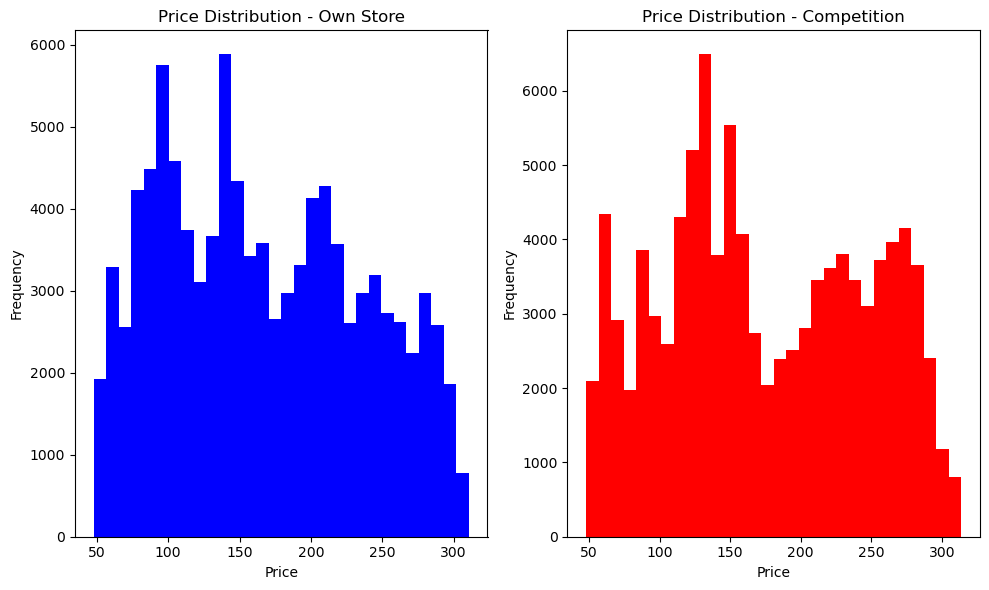

In [4]:
# comparing the price distribution with the competition

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.hist(df['Price'], bins=30, color='blue', label='Own Store')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Own Store')

plt.subplot(1, 2, 2)
plt.hist(df['Competition_Price'], bins=30, color='red', label='Competition')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Competition')

plt.tight_layout()
plt.show()

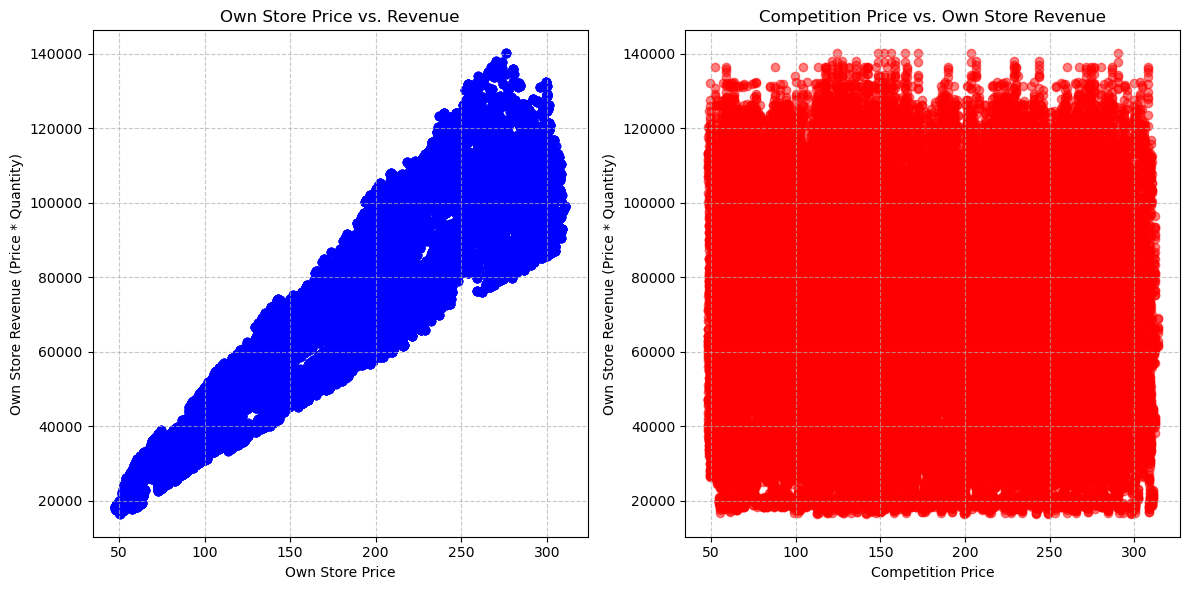

In [5]:
# Compare relationships between Price and our newly defined Revenue

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
# Using 'Revenue' column (Price * Item_Quantity) instead of 'Sales_Amount'
plt.scatter(df['Price'], df['Revenue'], color='blue', label='Own Store', alpha=0.5)
plt.xlabel('Own Store Price')
plt.ylabel('Own Store Revenue (Price * Quantity)')
plt.title('Own Store Price vs. Revenue')
plt.grid(True, linestyle='--', alpha=0.7)


plt.subplot(1, 2, 2)

# Here, for competition, we're comparing their price with *our* store's revenue.
# This plot primarily shows if our revenue has any visual correlation with competitor prices.

plt.scatter(df['Competition_Price'], df['Revenue'], color='red', label='Competition', alpha=0.5)
plt.xlabel('Competition Price')
plt.ylabel('Own Store Revenue (Price * Quantity)')
plt.title('Competition Price vs. Own Store Revenue')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

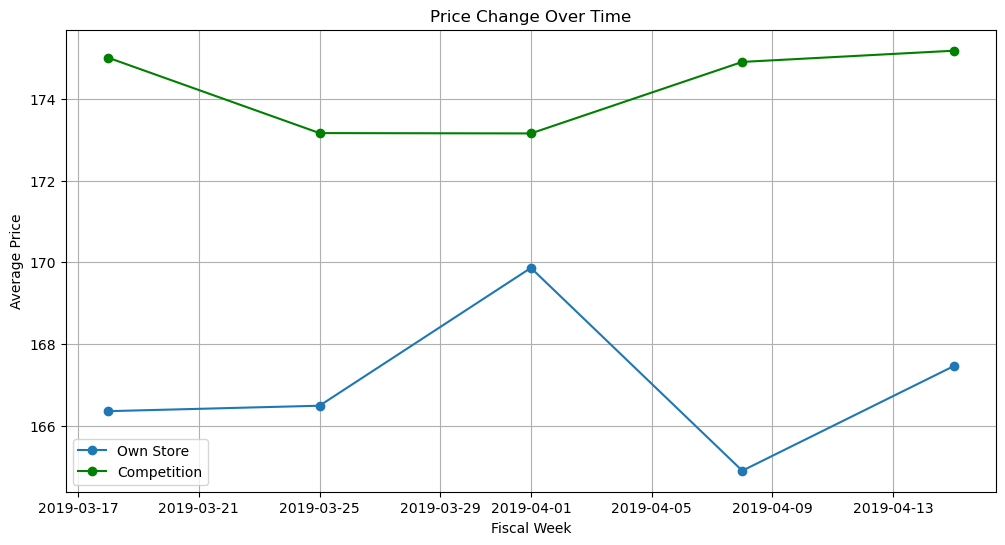

In [6]:
# compare price change over time

df['Fiscal_Week_ID'] = pd.to_datetime(df['Fiscal_Week_ID'] + '-1', format='%Y-%U-%w')

weekly_prices = df.groupby('Fiscal_Week_ID').agg({
    'Price': 'mean', 'Competition_Price': 'mean'
}).reset_index()

plt.figure(figsize=(12,6))

plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Price'], label='Own Store', marker='o')
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Competition_Price'], label='Competition', marker='o', color='green')

plt.xlabel('Fiscal Week')
plt.ylabel('Average Price')
plt.title('Price Change Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Calculate and compare the total sales amounts (Revenue) for our store and the competition

# Use our newly defined 'Revenue' column for own store sales
total_revenue_own = df['Revenue'].sum()

# For competition, we still use the proxy: Competition_Price * our Item_Quantity
total_revenue_competition = (df['Competition_Price'] * df['Item_Quantity']).sum()

total_qty_own = df['Item_Quantity'].sum()
total_qty_competition = df['Item_Quantity'].sum() # Assumption: quantities sold are same for comparison

summary = pd.DataFrame({
    'Metric': ['Total Revenue', 'Total Quantity Sold'],
    'Own Store': [total_revenue_own, total_qty_own],
    'Competition': [total_revenue_competition, total_qty_competition]
})

print(summary)

                Metric     Own Store   Competition
0        Total Revenue  6.601342e+09  6.965710e+09
1  Total Quantity Sold  3.996113e+07  3.996113e+07


  Price Bracket  Own Store Revenue  Competition Revenue
0          0-50       4.244868e+06         8.105461e+06
1        51-100       6.968463e+08         5.252767e+08
2       101-150       1.265876e+09         1.308102e+09
3       151-200       1.291495e+09         1.138420e+09
4       201-250       1.748658e+09         1.732585e+09
5       251-300       1.470184e+09         2.074060e+09
6       301-350       1.240372e+08         1.791621e+08
7       351-400       0.000000e+00         0.000000e+00
8       401-450       0.000000e+00         0.000000e+00
9       451-500       0.000000e+00         0.000000e+00


<Figure size 1200x700 with 0 Axes>

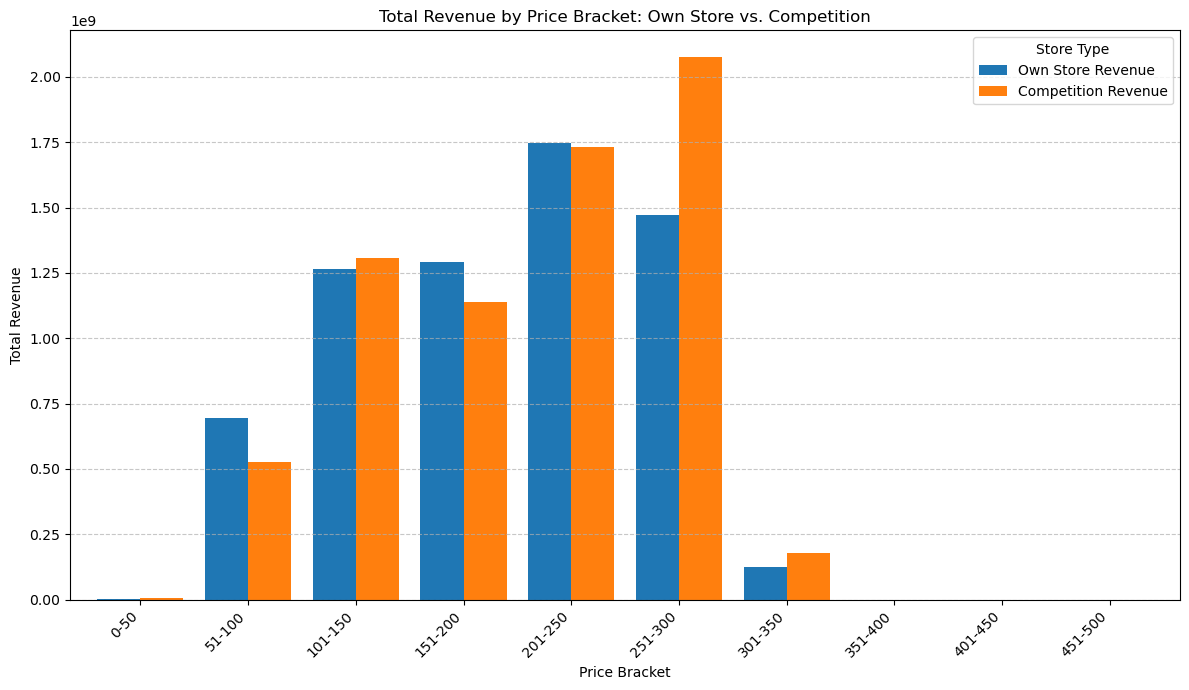

In [8]:
# Analyze how the sales amounts (Revenue) vary across different price brackets

# define price brackets
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500']

# create price brackets for both own store and competition
df['price_bracket'] = pd.cut(df['Price'], bins=bins, labels=labels, right=False, include_lowest=True) # Added include_lowest=True for 0 bin
df['competition_price_bracket'] = pd.cut(df['Competition_Price'], bins=bins, labels=labels, right=False, include_lowest=True) # Added include_lowest=True

# calculate revenue by price bracket for own store
# Using 'Revenue' column (Price * Item_Quantity)
revenue_by_bracket_own = df.groupby('price_bracket')['Revenue'].sum().reset_index()
revenue_by_bracket_own.columns = ['Price Bracket', 'Own Store Revenue']

# calculate revenue by price bracket for competition
# Using 'Competition_Price * Item_Quantity' as the proxy for competition revenue
df['competition_revenue'] = df['Competition_Price'] * df['Item_Quantity']
revenue_by_bracket_competition = df.groupby('competition_price_bracket')['competition_revenue'].sum().reset_index()
revenue_by_bracket_competition.columns = ['Price Bracket', 'Competition Revenue']

# merge the dataframes
revenue_by_bracket = pd.merge(revenue_by_bracket_own, revenue_by_bracket_competition, on='Price Bracket', how='outer')

# Fill NaNs ONLY in the numerical revenue columns
revenue_by_bracket['Own Store Revenue'].fillna(0, inplace=True)
revenue_by_bracket['Competition Revenue'].fillna(0, inplace=True)

# Ensure the 'Price Bracket' column retains its categorical order if needed for plotting
revenue_by_bracket['Price Bracket'] = pd.Categorical(revenue_by_bracket['Price Bracket'], categories=labels, ordered=True)
revenue_by_bracket = revenue_by_bracket.sort_values('Price Bracket').reset_index(drop=True)


print(revenue_by_bracket)

# Visualize the revenue by bracket
plt.figure(figsize=(12, 7))
revenue_by_bracket.set_index('Price Bracket').plot(kind='bar', figsize=(12, 7), width=0.8)
plt.title('Total Revenue by Price Bracket: Own Store vs. Competition')
plt.xlabel('Price Bracket')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Store Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

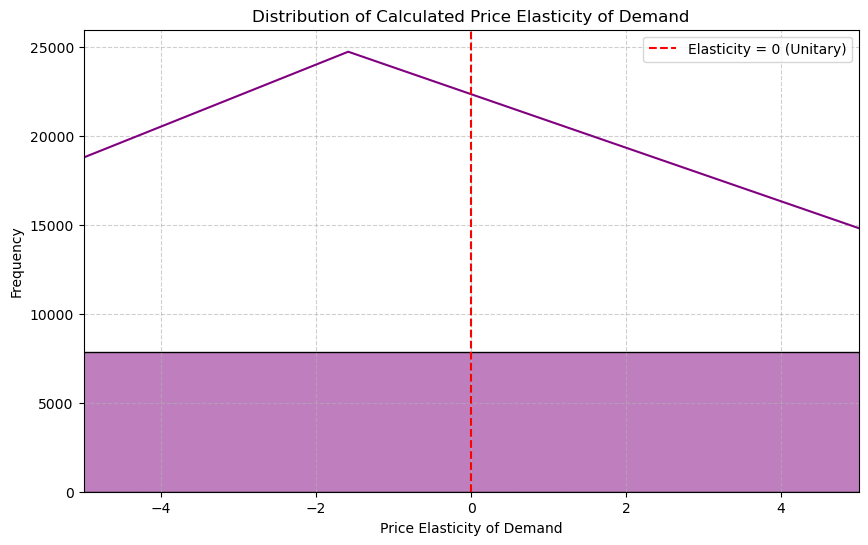


Descriptive Statistics of Price Elasticity:
count    8234.000000
mean       -0.461013
std        35.573810
min     -1455.268409
25%        -0.796818
50%         0.000000
75%         0.765515
max      1127.613636
Name: price_elasticity_item, dtype: float64

Number of valid (non-NaN) elasticity values: 8234


In [9]:
# Calculate and Visualize Price Elasticity

# Ensure data is sorted for correct pct_change()
df_sorted = df.sort_values(by=['Item_ID', 'Store_ID', 'Fiscal_Week_ID']).copy()

# Calculate price and quantity changes per item per store
df_sorted['price_change_item'] = df_sorted.groupby(['Item_ID', 'Store_ID'])['Price'].pct_change()
df_sorted['quantity_change_item'] = df_sorted.groupby(['Item_ID', 'Store_ID'])['Item_Quantity'].pct_change()

# Calculate item-level elasticity
df_sorted['price_elasticity_item'] = df_sorted['quantity_change_item'] / df_sorted['price_change_item']

# Handle infinite values and NaNs (from no change or division by zero)
df_sorted.replace([float('inf'), -float('inf')], np.nan, inplace=True)

# Drop NaNs specific to elasticity calculation
df_elasticity = df_sorted.dropna(subset=['price_elasticity_item']).copy()

# Visualization of Elasticity (e.g., average per week)
# Let's visualize the distribution of calculated elasticities.

plt.figure(figsize=(10, 6))
sns.histplot(df_elasticity['price_elasticity_item'], bins=50, kde=True, color='purple')
plt.xlabel('Price Elasticity of Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Calculated Price Elasticity of Demand')
plt.axvline(0, color='red', linestyle='--', label='Elasticity = 0 (Unitary)')
plt.xlim(-5, 5) # Limit x-axis to common elasticity range for better visibility
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Also, let's look at the descriptive statistics of the corrected elasticity
print("\nDescriptive Statistics of Price Elasticity:")
print(df_elasticity['price_elasticity_item'].describe())

# And how many non-NaN elasticity values we have
print(f"\nNumber of valid (non-NaN) elasticity values: {len(df_elasticity)}")

In [10]:
# Implement a dynamic pricing model and simulate its impact

# Create a copy of the dataset for simulation
# First, calculate average elasticity per ITEM_ID
# We take the mean, but median or mode could also be considered depending on distribution
item_avg_elasticity = df_elasticity.groupby('Item_ID')['price_elasticity_item'].mean().reset_index()
item_avg_elasticity.rename(columns={'price_elasticity_item': 'avg_item_elasticity'}, inplace=True)

# Merge this average elasticity back to the main DataFrame 'df'
dynamic_pricing_data = df.copy()
dynamic_pricing_data = pd.merge(dynamic_pricing_data, item_avg_elasticity, on='Item_ID', how='left')

# Handle items for which we couldn't calculate elasticity (NaN avg_item_elasticity)
# For simplicity, let's assume if an item has no calculated elasticity, it's unit elastic (-1)
# or you can use the overall average elasticity, or median. For now, let's use the overall average.
overall_avg_elasticity = df_elasticity['price_elasticity_item'].mean()
dynamic_pricing_data['avg_item_elasticity'].fillna(overall_avg_elasticity, inplace=True)

# Now, apply dynamic pricing rules based on segments AND elasticity
# Let's re-define segments based on Price_avg (which we will need to re-calculate as it was temporary in original df)
# Re-calculate average price and total quantity sold for each item (from original df)
item_summary = df.groupby('Item_ID').agg({
    'Price': 'mean',
    'Item_Quantity': 'sum'
}).reset_index()
item_summary.rename(columns={'Price': 'Price_avg', 'Item_Quantity': 'Item_Quantity_sum'}, inplace=True) # Rename for clarity

# Merge item summary back to the simulation dataset
dynamic_pricing_data = pd.merge(dynamic_pricing_data, item_summary[['Item_ID', 'Price_avg']], on='Item_ID', how='left')

# Define segments based on average price (using Price_avg)
dynamic_pricing_data['segment'] = pd.cut(dynamic_pricing_data['Price_avg'], bins=[0, 50, 150, 300, np.inf], labels=['Low', 'Medium', 'High', 'Very High']) # Added np.inf for max range

# Dynamic Pricing Strategy based on general elasticity principles
# Assuming items with higher (more negative) elasticity are price sensitive (decrease price)
# Assuming items with lower (closer to zero, less negative) elasticity are price inelastic (increase price)
# Let's re-evaluate our segments. The previous elasticity was positive. Now it's negative.
# If avg elasticity is -0.46, it's inelastic. If it's -2.0, it's elastic.

# Let's use simplified rules based on the overall (mean) elasticity being inelastic (-0.46).
# If demand is inelastic, increasing price generally increases revenue.
# However, we also want to be competitive.

# Let's refine the dynamic pricing rules:
# Rule 1: For 'Low' priced items (maybe less margin, high volume), keep prices stable or slightly increase if inelastic.
# Rule 2: For 'Medium' priced items, increase price if demand is inelastic.
# Rule 3: For 'High' priced items, adjust based on their specific elasticity or competitive position.
# Let's use the average elasticity *for that item* to determine the price change.

# Define a base price adjustment factor (e.g., 5%)
# This is where our model's strategy comes in.
# For demonstration, let's say:
# If avg_item_elasticity is between 0 and -1 (inelastic): Increase price.
# If avg_item_elasticity is < -1 (elastic): Consider decreasing price or keeping it stable if competitive.
# If avg_item_elasticity is > 0 (positive elasticity - usually means complex factors, or highly luxury/giffen goods): Could increase price.

# Let's set some simplified dynamic pricing logic:
# 1. If an item's average elasticity is between -1 and 0 (inelastic demand):
#    Increase price by 5%. This should increase total revenue.
# 2. If an item's average elasticity is less than -1 (elastic demand):
#    Decrease price by 5%. This should increase total quantity, and potentially total revenue if very elastic.
# 3. If an item's average elasticity is positive (unusual but occurs):
#    Increase price by 2%. (Assuming it might be a Veblen good or similar)

dynamic_pricing_data['dynamic_price'] = dynamic_pricing_data['Price'] # Initialize with current price

dynamic_pricing_data.loc[(dynamic_pricing_data['avg_item_elasticity'] >= -1) & (dynamic_pricing_data['avg_item_elasticity'] < 0), 'dynamic_price'] = dynamic_pricing_data['Price'] * 1.05
dynamic_pricing_data.loc[dynamic_pricing_data['avg_item_elasticity'] < -1, 'dynamic_price'] = dynamic_pricing_data['Price'] * 0.95
dynamic_pricing_data.loc[dynamic_pricing_data['avg_item_elasticity'] >= 0, 'dynamic_price'] = dynamic_pricing_data['Price'] * 1.02 # For positive elasticity

# --- Simulate New Quantity based on Elasticity ---
# Formula: New Quantity = Old Quantity * (1 + Elasticity * % Change in Price)
# % Change in Price = (New Price - Old Price) / Old Price

dynamic_pricing_data['price_percentage_change'] = (dynamic_pricing_data['dynamic_price'] - dynamic_pricing_data['Price']) / dynamic_pricing_data['Price']

dynamic_pricing_data['simulated_item_quantity'] = dynamic_pricing_data['Item_Quantity'] * (1 + dynamic_pricing_data['avg_item_elasticity'] * dynamic_pricing_data['price_percentage_change'])

# Ensure quantity doesn't go negative or unreasonably low
dynamic_pricing_data['simulated_item_quantity'] = np.maximum(0, dynamic_pricing_data['simulated_item_quantity'])


# Calculate new sales amounts (Revenue) based on dynamic prices AND simulated quantities
dynamic_pricing_data['dynamic_revenue'] = dynamic_pricing_data['dynamic_price'] * dynamic_pricing_data['simulated_item_quantity']

# Compare total sales amount (Revenue) between existing and dynamic pricing
total_revenue_existing = df['Revenue'].sum() # Using our newly defined Revenue
total_revenue_dynamic = dynamic_pricing_data['dynamic_revenue'].sum()

# Compare total quantity sold between existing and dynamic pricing
total_qty_existing = df['Item_Quantity'].sum()
total_qty_dynamic = dynamic_pricing_data['simulated_item_quantity'].sum() # Now using simulated quantity

comparison_summary = pd.DataFrame({
    'Metric': ['Total Revenue', 'Total Quantity Sold'],
    'Existing Pricing': [total_revenue_existing, total_qty_existing],
    'Dynamic Pricing (Simulated)': [total_revenue_dynamic, total_qty_dynamic]
})

print(comparison_summary)

                Metric  Existing Pricing  Dynamic Pricing (Simulated)
0        Total Revenue      6.601342e+09                 7.266980e+09
1  Total Quantity Sold      3.996113e+07                 4.372029e+07


In [11]:
# Ensure Fiscal_Week_ID is in datetime format for merging
if not pd.api.types.is_datetime64_any_dtype(df['Fiscal_Week_ID']):
    df['Fiscal_Week_ID'] = pd.to_datetime(df['Fiscal_Week_ID'] + '-1', format='%Y-%U-%w')
if not pd.api.types.is_datetime64_any_dtype(dynamic_pricing_data['Fiscal_Week_ID']):
    dynamic_pricing_data['Fiscal_Week_ID'] = pd.to_datetime(dynamic_pricing_data['Fiscal_Week_ID'] + '-1', format='%Y-%U-%w')

# Prepare the calculated dynamic results for merging
# Create a slim DataFrame with the unique keys and the desired calculated columns.
# Using .drop_duplicates() here ensures 'calculated_dynamic_results' has only one entry
# for each unique (Fiscal_Week_ID, Store_ID, Item_ID) combination.
calculated_dynamic_results = dynamic_pricing_data[[
    'Fiscal_Week_ID', 'Store_ID', 'Item_ID',
    'dynamic_price', 'simulated_item_quantity', 'dynamic_revenue'
]].drop_duplicates(subset=['Fiscal_Week_ID', 'Store_ID', 'Item_ID']).copy()

# Perform the merge
# Use a left merge to ensure all original df rows are kept.
cols_to_drop_pre_merge = [col for col in ['dynamic_price', 'simulated_item_quantity', 'dynamic_revenue'] if col in df.columns]
if cols_to_drop_pre_merge:
    print(f"Dropping pre-existing columns from df before merge: {cols_to_drop_pre_merge}")
    df.drop(columns=cols_to_drop_pre_merge, inplace=True)

# Now merge, no suffixes needed since we're cleaning 'df' beforehand
df = pd.merge(df, calculated_dynamic_results,
              on=['Fiscal_Week_ID', 'Store_ID', 'Item_ID'],
              how='left')

# Remove Exact Duplicates from the Entire DataFrame
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - df.shape[0]} exact duplicate rows.")

# Handle potential dynamic_price_x/y or other suffix issues
# This cleanup ensures we have a single, correctly named dynamic price column.
if 'dynamic_price_x' in df.columns and 'dynamic_price_y' in df.columns:
    df['dynamic_price'] = df['dynamic_price_y'] # Keep the one from the most recent merge
    df.drop(columns=['dynamic_price_x', 'dynamic_price_y'], inplace=True)
elif 'dynamic_price_calculated' in df.columns and 'dynamic_price_original' in df.columns:
    df['dynamic_price'] = df['dynamic_price_calculated']
    df.drop(columns=['dynamic_price_original', 'dynamic_price_calculated'], inplace=True)

# Also check for _original and _calculated suffixes for quantity and revenue
columns_to_rename = {
    'simulated_item_quantity_calculated': 'simulated_item_quantity',
    'dynamic_revenue_calculated': 'dynamic_revenue',
    'simulated_item_quantity_original': 'simulated_item_quantity', # In case 'calculated' wasn't there
    'dynamic_revenue_original': 'dynamic_revenue' # In case 'calculated' wasn't there
}

for old_name, new_name in columns_to_rename.items():
    if old_name in df.columns and old_name != new_name: # Ensure it exists and isn't already renamed
        # Check if the desired new name already exists before renaming
        if new_name in df.columns and old_name in df.columns:
            # If new name exists, and old name also exists, and they refer to the same logical column (which they should)
            # we need to be careful. In this specific scenario, the values are identical, so we can drop the old_name.
            print(f"Dropping redundant column: {old_name}")
            df.drop(columns=[old_name], inplace=True)
        elif old_name in df.columns: # If the new name doesn't exist, just rename
            df.rename(columns={old_name: new_name}, inplace=True)

# Final check for any remaining unexpected _original or _calculated columns and drop them
cols_to_clean = [col for col in df.columns if '_original' in col or '_calculated' in col]
if cols_to_clean:
    print(f"Dropping residual _original/_calculated columns: {cols_to_clean}")
    df.drop(columns=cols_to_clean, inplace=True)


# Verify the final shape and head
print("Final DataFrame shape after cleaning and deduplication:", df.shape)
print("Final DataFrame columns:", df.columns.tolist())
df.head()

# Save the updated DataFrame to a new CSV file
# Using a new name 'Clean_Final' to distinguish the truly cleaned version.
df.to_csv('Competition_Data_Dynamic_Pricing_Updated.csv', index=False)
print("DataFrame saved successfully as 'Competition_Data_Dynamic_Pricing_Updated.csv'")

Removed 0 exact duplicate rows.
Final DataFrame shape after cleaning and deduplication: (100000, 16)
Final DataFrame columns: ['Index', 'Fiscal_Week_ID', 'Store_ID', 'Item_ID', 'Price', 'Item_Quantity', 'Sales_Amount_No_Discount', 'Sales_Amount', 'Competition_Price', 'Revenue', 'price_bracket', 'competition_price_bracket', 'competition_revenue', 'dynamic_price', 'simulated_item_quantity', 'dynamic_revenue']
DataFrame saved successfully as 'Competition_Data_Dynamic_Pricing_Updated.csv'


In [12]:
df.head()

,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price,Revenue,price_bracket,competition_price_bracket,competition_revenue,dynamic_price,simulated_item_quantity,dynamic_revenue
0,0,2019-03-18,store_459,item_526,134.49,435,4716.74,11272.59,206.44,58503.15,101-150,201-250,89801.40,127.7655,485.326606,62007.996513
1,1,2019-03-18,store_459,item_526,134.49,435,4716.74,11272.59,158.01,58503.15,101-150,151-200,68734.35,127.7655,485.326606,62007.996513
2,2,2019-03-18,store_459,item_526,134.49,435,4716.74,11272.59,278.03,58503.15,101-150,251-300,120943.05,127.7655,485.326606,62007.996513
3,3,2019-03-18,store_459,item_526,134.49,435,4716.74,11272.59,222.66,58503.15,101-150,201-250,96857.10,127.7655,485.326606,62007.996513
4,4,2019-03-18,store_459,item_526,134.49,435,4716.74,11272.59,195.32,58503.15,101-150,151-200,84964.20,127.7655,485.326606,62007.996513


In [13]:
# Prepare the elasticity data for merging
# Ensure dynamic_pricing_data has unique Item_ID for elasticity
# Since 'avg_item_elasticity' was calculated by grouping by 'Item_ID', it should already be unique.
# However, it's good practice to ensure uniqueness before merging.
elasticity_to_merge = dynamic_pricing_data[['Item_ID', 'avg_item_elasticity']].drop_duplicates(subset=['Item_ID']).copy()

# Merge avg_item_elasticity into df
# Use a left merge to keep all rows from df and add the elasticity where Item_ID matches.
df = pd.merge(df, elasticity_to_merge, on='Item_ID', how='left')

# Verify the merge
print("DataFrame shape after merging elasticity:", df.shape)
print("Columns in df after merging elasticity:", df.columns.tolist())
print("\nHead of df with new elasticity column:")
print(df[['Item_ID', 'Price', 'Item_Quantity', 'avg_item_elasticity']].head())

# Check for any NaNs in avg_item_elasticity to see if all items found a match
print(f"\nNumber of rows with missing elasticity: {df['avg_item_elasticity'].isnull().sum()}")

DataFrame shape after merging elasticity: (100000, 17)
Columns in df after merging elasticity: ['Index', 'Fiscal_Week_ID', 'Store_ID', 'Item_ID', 'Price', 'Item_Quantity', 'Sales_Amount_No_Discount', 'Sales_Amount', 'Competition_Price', 'Revenue', 'price_bracket', 'competition_price_bracket', 'competition_revenue', 'dynamic_price', 'simulated_item_quantity', 'dynamic_revenue', 'avg_item_elasticity']

Head of df with new elasticity column:
    Item_ID   Price  Item_Quantity  avg_item_elasticity
0  item_526  134.49            435            -2.313867
1  item_526  134.49            435            -2.313867
2  item_526  134.49            435            -2.313867
3  item_526  134.49            435            -2.313867
4  item_526  134.49            435            -2.313867

Number of rows with missing elasticity: 0


In [14]:
def simulate_price_scenarios_with_elasticity(row, percentage_changes=[-0.2, -0.1, 0, 0.1, 0.2]):
    results = []
    original_price = row['Price']
    original_quantity = row['Item_Quantity']
    elasticity = row['avg_item_elasticity'] # Get the elasticity for the current item

    for pct_change in percentage_changes:
        new_price = original_price * (1 + pct_change)

        # Calculate new quantity using the price elasticity formula
        # Quantity_new = Quantity_original * (1 + Elasticity * %_Change_in_Price)
        # Ensure quantity does not go below zero
        simulated_quantity = max(0, original_quantity * (1 + elasticity * pct_change))

        simulated_revenue = new_price * simulated_quantity
        results.append((pct_change, new_price, simulated_quantity, simulated_revenue))
    return results

simulation_results_elasticity = []

for index, row in df.iterrows():
    
    if not pd.isna(row['avg_item_elasticity']):
        scenarios = simulate_price_scenarios_with_elasticity(row)
        for pct_change, new_price, simulated_quantity, simulated_revenue in scenarios:
            simulation_results_elasticity.append({
                'Index': index, # Original DataFrame index
                'Fiscal_Week_ID': row['Fiscal_Week_ID'],
                'Store_ID': row['Store_ID'],
                'Item_ID': row['Item_ID'],
                'Original_Price': row['Price'],
                'Original_Quantity': row['Item_Quantity'],
                'Original_Revenue': row['Revenue'], # Include original revenue for comparison
                'Avg_Item_Elasticity': row['avg_item_elasticity'],
                'Pct_Change_Applied': pct_change,
                'New_Price_Simulated': new_price,
                'Simulated_Quantity': simulated_quantity,
                'Simulated_Revenue': simulated_revenue
            })

# Convert the results to a DataFrame
sim_df_elasticity = pd.DataFrame(simulation_results_elasticity)

print("\nHead of simulation results with elasticity:")
print(sim_df_elasticity.head(10)) # Show more rows to see different scenarios for the same Index

print("\nShape of simulation results with elasticity:", sim_df_elasticity.shape)


Head of simulation results with elasticity:
   Index Fiscal_Week_ID   Store_ID   Item_ID  Original_Price  \
0      0     2019-03-18  store_459  item_526          134.49   
1      0     2019-03-18  store_459  item_526          134.49   
2      0     2019-03-18  store_459  item_526          134.49   
3      0     2019-03-18  store_459  item_526          134.49   
4      0     2019-03-18  store_459  item_526          134.49   
5      1     2019-03-18  store_459  item_526          134.49   
6      1     2019-03-18  store_459  item_526          134.49   
7      1     2019-03-18  store_459  item_526          134.49   
8      1     2019-03-18  store_459  item_526          134.49   
9      1     2019-03-18  store_459  item_526          134.49   

   Original_Quantity  Original_Revenue  Avg_Item_Elasticity  \
0                435          58503.15            -2.313867   
1                435          58503.15            -2.313867   
2                435          58503.15            -2.313867  

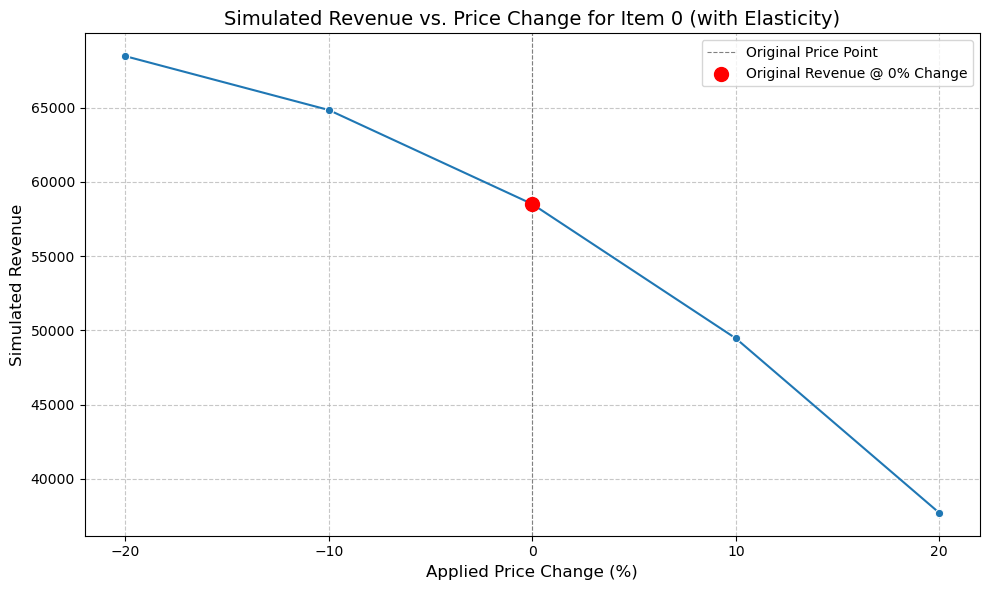

In [15]:
# Select a sample item (e.g., using the first original 'Index' value)
# We need to make sure the 'Index' column in sim_df_elasticity refers to the original DataFrame's index.
# Let's take the first unique original Index from sim_df_elasticity
sample_original_index = sim_df_elasticity['Index'].iloc[0]
sample = sim_df_elasticity[sim_df_elasticity['Index'] == sample_original_index].copy()

# Ensure Pct_Change_Applied is numerical and sorted for a proper line plot
sample['Pct_Change_Applied_Display'] = sample['Pct_Change_Applied'] * 100 # Convert to percentage for display
sample = sample.sort_values(by='Pct_Change_Applied_Display') # Sort for correct line progression

plt.figure(figsize=(10, 6))
sns.lineplot(data=sample, x='Pct_Change_Applied_Display', y='Simulated_Revenue', marker='o')

# Add the original revenue point for comparison at 0% change
# The '0.0' pct_change row corresponds to the original price and quantity
original_revenue_point = sample[sample['Pct_Change_Applied_Display'] == 0]
if not original_revenue_point.empty:
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, label='Original Price Point')
    plt.scatter(original_revenue_point['Pct_Change_Applied_Display'],
                original_revenue_point['Simulated_Revenue'],
                color='red', s=100, zorder=5, label='Original Revenue @ 0% Change')


plt.title(f"Simulated Revenue vs. Price Change for Item {sample_original_index} (with Elasticity)", fontsize=14)
plt.xlabel("Applied Price Change (%)", fontsize=12)
plt.ylabel("Simulated Revenue", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(sample['Pct_Change_Applied_Display'].unique()) # Ensure ticks at each scenario
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df['dynamic_lift'] = df['dynamic_revenue'] - df['Revenue']
df['lift_percent'] = df['dynamic_lift'] / df['Revenue'] * 100

In [17]:
df['lift_percent'].describe()

count    100000.000000
mean         13.830897
std          39.650970
min         -68.868322
25%           2.371116
50%           3.839419
75%           7.718971
max         323.438186
Name: lift_percent, dtype: float64

Text(0.5, 1.0, 'Revenue Improvement from Dynamic Pricing (%)')

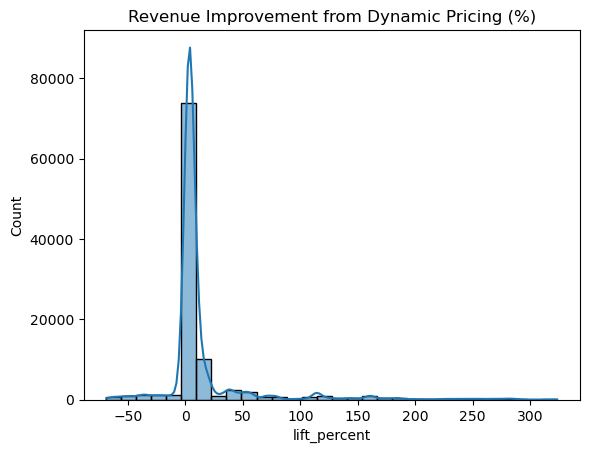

In [18]:
sns.histplot(df['lift_percent'], bins=30, kde=True)
plt.title('Revenue Improvement from Dynamic Pricing (%)')